In [45]:
import os
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch import optim

from utils.configs import Configs, model_dict
from data_provider.data_factory import data_provider
from utils.tools import EarlyStopping, adjust_learning_rate
from experiments.quantile_calibrator import compute_PICP_torch
from experiments.conformal_calibrator import compute_kappa_from_R, conformal_intervals, ConformalScaleNet

In [46]:
args = Configs(data='ELC', root_path='/nfs/daojun/Data/TS_Small/')
print("load model ...")
path = os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')
print(path)
device = torch.device('cuda:0' if args.use_gpu else 'cpu')
model = model_dict[args.model].Model(args).float().to(device)
model.load_state_dict(torch.load(path))
model.eval()

load model ...
./checkpoints/ELC_96_96_iTransformer_custom_S_ft96_sl48_ll96_pl512_dm8_nh2_el1_dl2048_df1_fctimeF_ebTrue_dttest_projection_0/checkpoint.pth


Model(
  (enc_embedding): DataEmbedding_inverted(
    (value_embedding): Linear(in_features=96, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): Encoder(
    (attn_layers): ModuleList(
      (0-1): 2 x EncoderLayer(
        (attention): AttentionLayer(
          (inner_attention): FullAttention(
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (query_projection): Linear(in_features=512, out_features=512, bias=True)
          (key_projection): Linear(in_features=512, out_features=512, bias=True)
          (value_projection): Linear(in_features=512, out_features=512, bias=True)
          (out_projection): Linear(in_features=512, out_features=512, bias=True)
        )
        (conv1): Conv1d(512, 2048, kernel_size=(1,), stride=(1,))
        (conv2): Conv1d(2048, 512, kernel_size=(1,), stride=(1,))
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwi

In [47]:
_, vali_loader = data_provider(args, 'val')
_, train_loader = data_provider(args, 'train')
_, test_loader = data_provider(args, 'test')

val 2537
train 18221
test 5165


In [48]:
def _get_ccal_model():
    ccal = ConformalScaleNet(args.seq_len, args.enc_in, args.pred_len, args.c_out).to(device)
    return ccal

In [49]:
@torch.no_grad()
def fit_conformal_kappa(scalnet, calib_loader, per_dim=False, device='cpu'):
    R=[]
    for step, (xb, yb, xb_mark, yb_mark) in enumerate(calib_loader):
        xb = xb.float().to(device)
        yb = yb.float().to(device)
        xb_mark = xb_mark.float().to(device)
        yb_mark = yb_mark.float().to(device)

        f_dim = -1 if args.features == 'MS' else 0
        yb = yb[:, -args.pred_len:, f_dim:].to(device)
        
        yhat = model(xb,xb_mark,  yb, yb_mark)

        w=scalnet(xb,yhat)
        r=(yb - yhat).abs()/(w+1e-6)
        R.append(r.cpu())
    R=torch.cat(R,dim=0)  # [N,H,m]
    return R if per_dim else R.view(-1)

In [50]:
def train_conformal_calibrator(lr=1e-3, lambda_reg=1e-3, max_epochs=10, patience=5):

        print('train conformal calibrator ...')
        print("load model ...")
        model.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')))
        model.eval().to(device)

        scalnet = _get_ccal_model()
        for p in model.parameters(): p.requires_grad=False
        
        model.eval().to(device)
        scalnet.to(device).train()

        opt=torch.optim.AdamW(scalnet.parameters(), lr=lr, weight_decay=1e-4)
        path = os.path.join(args.checkpoints, args.setting)

        best=float("inf")
        bad=0
        best_state=None
        for ep in range(max_epochs):
            loss_list=[]
            for step, (xb, yb, xb_mark, yb_mark) in enumerate(train_loader):
                with torch.no_grad(): 
                    xb = xb.float().to(device)
                    yb = yb.float().to(device)
                    xb_mark = xb_mark.float().to(device)
                    yb_mark = yb_mark.float().to(device)

                    f_dim = -1 if args.features == 'MS' else 0
                    yb = yb[:, -args.pred_len:, f_dim:].to(device)
                    
                    yhat = model(xb,  xb_mark, yb, yb_mark)
                w=scalnet(xb,yhat)
                res=(yb - yhat).abs()
                loss=(res/(w+1e-6)).mean() + lambda_reg*((w-1.0)**2).mean()
                loss_list.append(loss.item())
                opt.zero_grad(set_to_none=True)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(scalnet.parameters(),1.0); opt.step()

                if (step+1) % 100 == 0:
                    print({'step': '%d' % (step+1), 'loss': '%.4f' % np.mean(loss_list)})
            
            if vali_loader is not None:
                scalnet.eval()
                val=0.0; n=0
                with torch.no_grad():
                    for step, (xb, yb, xb_mark, yb_mark) in enumerate(vali_loader):
                        xb = xb.float().to(device)
                        yb = yb.float().to(device)
                        xb_mark = xb_mark.float().to(device)
                        yb_mark = yb_mark.float().to(device)

                        f_dim = -1 if args.features == 'MS' else 0
                        yb = yb[:, -args.pred_len:, f_dim:].to(device)
                        
                        yhat = model(xb, xb_mark, yb, yb_mark)

                        w=scalnet(xb,yhat)
                        res=(yb - yhat).abs()
                        loss=(res/(w+1e-6)).mean() + lambda_reg*((w-1.0)**2).mean()
                        val += loss.item()*xb.size(0)
                        n+=xb.size(0)
                val/=max(n,1)
                print('val loss=%.4f' % val)
                scalnet.train()
                if val<best: 
                    best,val_best = val, val
                    bad=0
                    best_state={k:v.cpu() for k,v in scalnet.state_dict().items()}
                    torch.save(scalnet.state_dict(), path + '/' + 'ccal_ckpt_2.pth')
                else: 
                    bad +=1
                if bad>=patience: break
        if best_state is not None: scalnet.load_state_dict(best_state)

        print("ScaleNet trained. Best val loss:", val_best)

In [51]:
def test_conformal_calibrator(scalnet=None, alpha=0.05):
    print('test conformal calibrator ...')
    print("load model ...")
    model.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')))
    model.eval().to(device)
    if scalnet is None:
        scalnet = _get_ccal_model()
        scalnet.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'ccal_ckpt.pth')))
    scalnet.eval().to(device)

    R = fit_conformal_kappa(scalnet, vali_loader, per_dim=False, device=device)
    kappa = compute_kappa_from_R(R, alpha, per_dim=False)
    print("Conformal kappa (global):", float(kappa))

    picp_list = []
    picp_list2 = []
    # Coverage diagnostic on test:
    with torch.no_grad():
        inside, total = 0, 0
        for step, (xb, yb, xb_mark, yb_mark) in enumerate(test_loader):
            xb = xb.float().to(device)
            yb = yb.float().to(device)
            xb_mark = xb_mark.float().to(device)
            yb_mark = yb_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            yb = yb[:, -args.pred_len:, f_dim:].to(device)
            
            yhat = model(xb,  xb_mark, yb, yb_mark)

            w=scalnet(xb,yhat)

            lo, hi = conformal_intervals(w, yhat, kappa, alpha, per_dim=False)
            ok = ((yb >= lo) & (yb <= hi)).float()
            inside += ok.mean().item()*xb.size(0)  # averaged across H,m per batch
            total  += xb.size(0)

            picp_list.append(ok.mean().item())
            
            pred = torch.cat((lo, yhat, hi), dim=-1)#.detach().cpu().numpy()  # [B,H,m,2]
            coverage, _, _ = compute_PICP_torch(yb, pred)
            picp_list2.append(coverage.item())

        print("Avg per-example coverage (≈ target 1-alpha):", inside/total)
        print('mean picp= ', np.mean(picp_list))
        print('mean picp= ', np.mean(picp_list2))

In [52]:
train_conformal_calibrator(max_epochs=1)

train conformal calibrator ...
load model ...


{'step': '100', 'loss': '0.0942'}
{'step': '200', 'loss': '0.0826'}
{'step': '300', 'loss': '0.0786'}
{'step': '400', 'loss': '0.0766'}
{'step': '500', 'loss': '0.0753'}
val loss=0.0769
ScaleNet trained. Best val loss: 0.07691459084236169


In [53]:

test_conformal_calibrator()

test conformal calibrator ...
load model ...


Conformal kappa (global): 0.1738072782754898
Avg per-example coverage (≈ target 1-alpha): 0.9550359111556933
mean picp=  0.9550359111556933
mean picp=  0.5763034550402771


In [54]:
%matplotlib inline  
import matplotlib.pyplot as plt
print('test conformal calibrator ...')
print("load model ...")
model.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'checkpoint.pth')))
model.eval().to(device)

scalnet = _get_ccal_model()
scalnet.load_state_dict(torch.load(os.path.join('./checkpoints/' + args.setting, 'ccal_ckpt.pth')))
scalnet.eval().to(device)
R = fit_conformal_kappa(scalnet, vali_loader, per_dim=False, device=device)



test conformal calibrator ...
load model ...


In [71]:
def vis_sample_with_conf_cali(alpha=0.05):
    
    kappa = compute_kappa_from_R(R, alpha, per_dim=False)
    print("Conformal kappa (global):", float(kappa))
        
    picp_list = []

    indexes = np.random.randint(0, len(test_loader), 10)
    print("Randomly selected sample indexes for visualization: ", indexes)
    # Coverage diagnostic on test:
    with torch.no_grad():
        inside, total = 0, 0
        for step, (xb, yb, xb_mark, yb_mark) in enumerate(test_loader):
            if step not in [0, 908, 3000, 3331, 3800]:
                continue
            xb = xb.float().to(device)
            yb = yb.float().to(device)
            xb_mark = xb_mark.float().to(device)
            yb_mark = yb_mark.float().to(device)

            f_dim = -1 if args.features == 'MS' else 0
            yb = yb[:, -args.pred_len:, f_dim:].to(device)
            
            yhat = model(xb,  xb_mark, yb, yb_mark)

            w=scalnet(xb,yhat)

            lo, hi = conformal_intervals(w, yhat, kappa, alpha, per_dim=False)
            ok = ((yb >= lo) & (yb <= hi)).float()
            inside += ok.mean().item()*xb.size(0)  # averaged across H,m per batch
            total  += xb.size(0)

            picp_list.append(ok.mean().item())
            
            print(step,'picp=',ok.mean().item())
            plt.rcParams.update({"font.size":22})
            plt.figure(figsize=(10,6))
            plt.plot(yb[0,:,0].cpu().numpy(), label='Truth', color='blue', linewidth=2)
            plt.plot(yhat[0,:,0].cpu().numpy(), label='Prediction', color='red', linewidth=2)
            plt.fill_between(np.arange(yhat.size(1)), lo[0,:,0].cpu().numpy(), hi[0,:,0].cpu().numpy(), color='lightcoral', alpha=0.5, label='Conformal Calibrated Interval')
            plt.legend()
            plt.title(f'Sample with Conformal Calibration (PICP: {ok.mean().item():.3f})')
            plt.show()
            

        print("Avg per-example coverage (≈ target 1-alpha):", inside/total)
        print('mean picp= ', np.mean(picp_list))

Conformal kappa (global): 0.07426966726779938
Randomly selected sample indexes for visualization:  [ 733 1108 1393 4662 1518 1671 1218 1241  460 3532]


0 picp= 0.6979166865348816


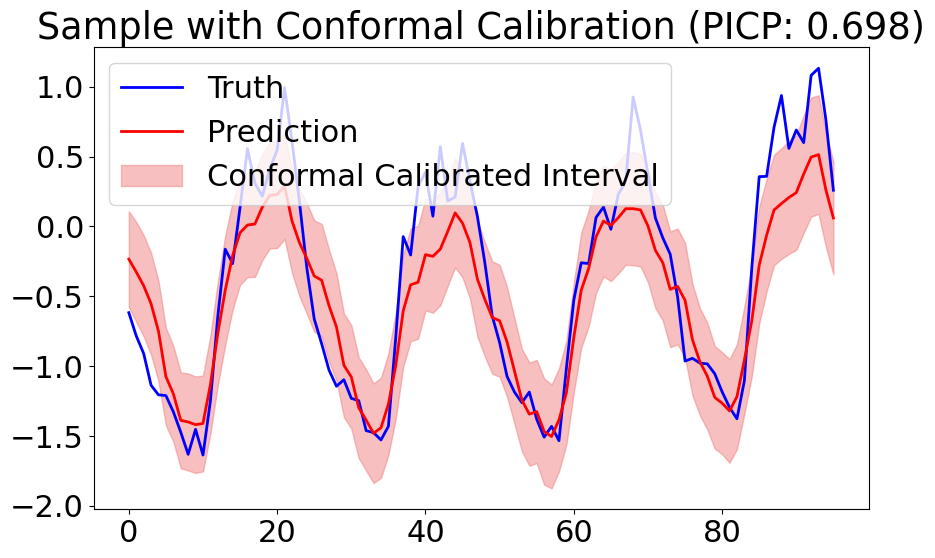

908 picp= 0.6770833730697632


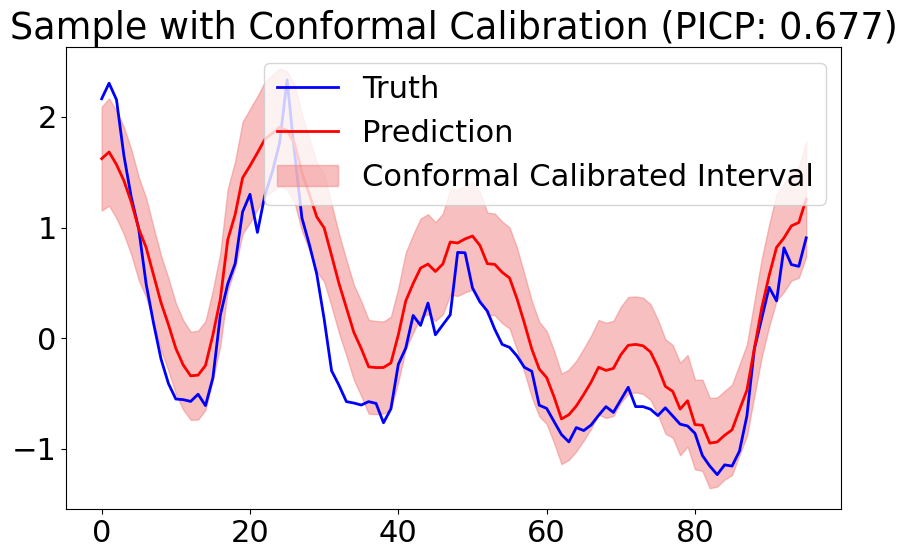

3000 picp= 0.5625


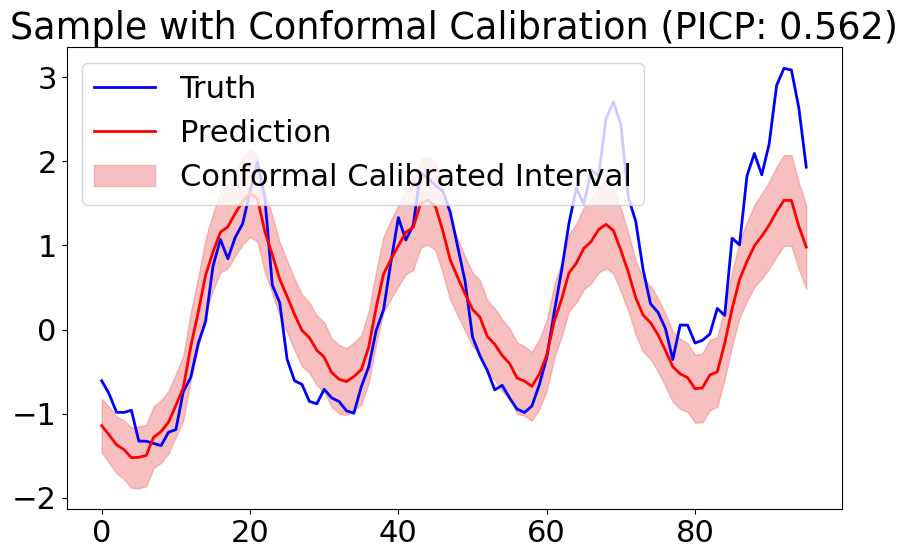

3331 picp= 0.6770833730697632


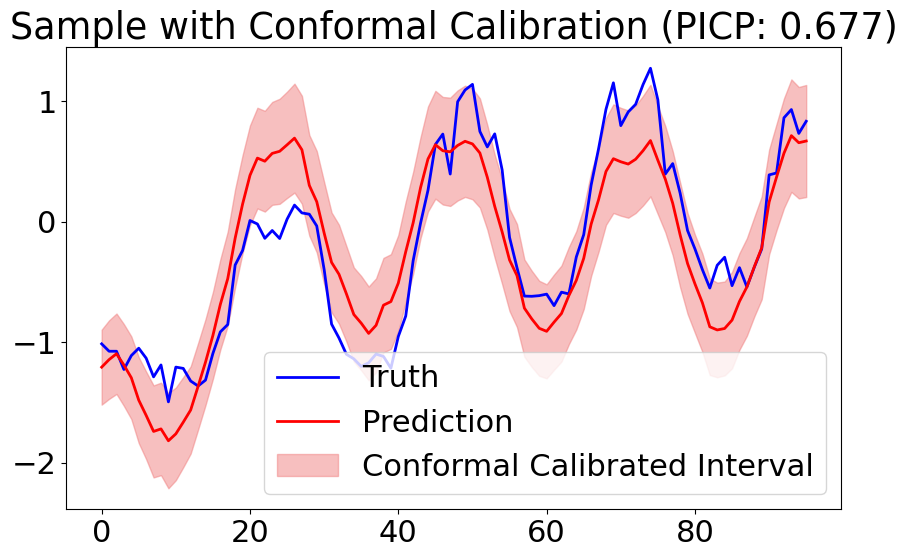

3800 picp= 0.6875


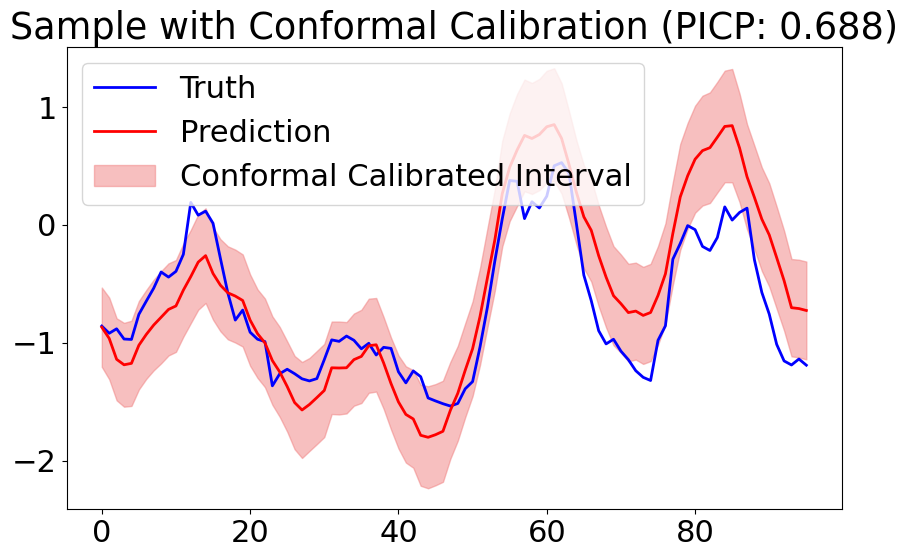

Avg per-example coverage (≈ target 1-alpha): 0.6604166865348816
mean picp=  0.6604166865348816


In [72]:
vis_sample_with_conf_cali(alpha=0.25)